In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.colors as pc
from modified_spectral_method import *
from modified_louvain_method import *
from proxy_methods_final import *
import cvxpy as cp
import copy
import matplotlib.pyplot as plt

In [70]:
#Prices data
#-----------------------------------------
prices_data = pd.read_csv('data/reshaped_data.csv')
prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)
prices_data = prices_data.set_index('Date')

#Index data
#-----------------------------------------
index_data = pd.read_csv('ITRAXX-Europe Timeseries 20241127.csv') #To be used for b0
index_data.rename(columns={'AsOf':'Date'}, inplace=True)
try:
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d-%b-%y')
except Exception as e:
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d/%b/%y')
index_data = index_data.sort_values(by='Date', ascending=True)
#Metadata
#-----------------------------------------
metadata = pd.read_csv('data/metadata_batched_ratings.csv')

#Community detection
#-----------------------------------------
correlation_matrix,T,N,company_names = create_correlation_matrix('data/eur_data_standardized_returns2.csv')
C_g = calculate_C_g(correlation_matrix, T, N)
result_communities, company_communities, modularities = recursive_spectral_method(C_g, correlation_matrix, company_names, min_size=2, modularity_threshold=0.00001)

C:\Users\iChin\AppData\Local\Temp\ipykernel_4712\820024360.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)


### Choosing community by one or two factors (Sector, Country, Rating)

In [54]:
# Analyze bucket distribution for each community
community_buckets = []

for i, community in enumerate(company_communities):
    community_bucket_distribution = {}

    for ticker in community:
        # Get the bucket for the ticker
        bucket, _ = get_bucket(metadata, company_communities, ticker)

        if bucket:
            # Create a string representation of the bucket for easy grouping
            bucket_key = f"{bucket['Sector']}, {bucket['Country']}, {bucket['Rating']}"
            
            # Count the occurrences of each bucket
            if bucket_key in community_bucket_distribution:
                community_bucket_distribution[bucket_key] += 1
            else:
                community_bucket_distribution[bucket_key] = 1

    community_buckets.append({
        'Community': i + 1,
        'Bucket_Distribution': community_bucket_distribution
    })

#Display bucket distributions
for community_bucket in community_buckets:
    print(f"Community {community_bucket['Community']}:")
    for bucket, count in community_bucket['Bucket_Distribution'].items():
        print(f"  Bucket: {bucket}, Count: {count}")
    print()

Community 1:
  Bucket: Financials, France, Upper Medium Grade, Count: 4
  Bucket: Financials, Netherlands, Lower Medium Grade, Count: 1
  Bucket: Financials, Greece, Lower Medium Grade, Count: 1
  Bucket: Financials, Germany, High Grade, Count: 1
  Bucket: Financials, Italy, Lower Medium Grade, Count: 4
  Bucket: Financials, United Kingdom, Upper Medium Grade, Count: 4
  Bucket: Financials, France, Lower Medium Grade, Count: 1
  Bucket: Financials, Spain, Upper Medium Grade, Count: 2
  Bucket: Financials, Germany, Lower Medium Grade, Count: 2
  Bucket: Financials, Switzerland, Lower Medium Grade, Count: 2
  Bucket: Financials, Denmark, Upper Medium Grade, Count: 1
  Bucket: Financials, Germany, Upper Medium Grade, Count: 1
  Bucket: Government, Germany, Lower Medium Grade, Count: 1
  Bucket: Utilities, Portugal, Lower Medium Grade, Count: 1
  Bucket: Utilities, Italy, Lower Medium Grade, Count: 1
  Bucket: Government, Finland, Lower Medium Grade, Count: 1
  Bucket: Utilities, Spain, Up

Community 1:
  Rating: Lower Medium Grade, Count: 21
  Rating: Upper Medium Grade, Count: 14
  Rating: High Grade, Count: 2
  Rating: Extremely Speculative, Count: 2
  Rating: Non-Investment Grade, Count: 1

Community 2:
  Rating: Lower Medium Grade, Count: 41
  Rating: Upper Medium Grade, Count: 15
  Rating: Extremely Speculative, Count: 14
  Rating: Highly Speculative, Count: 7
  Rating: High Grade, Count: 6
  Rating: Non-Investment Grade, Count: 2

Community 3:
  Rating: Lower Medium Grade, Count: 128
  Rating: Upper Medium Grade, Count: 28
  Rating: Extremely Speculative, Count: 20
  Rating: Highly Speculative, Count: 5
  Rating: High Grade, Count: 5
  Rating: Non-Investment Grade, Count: 5



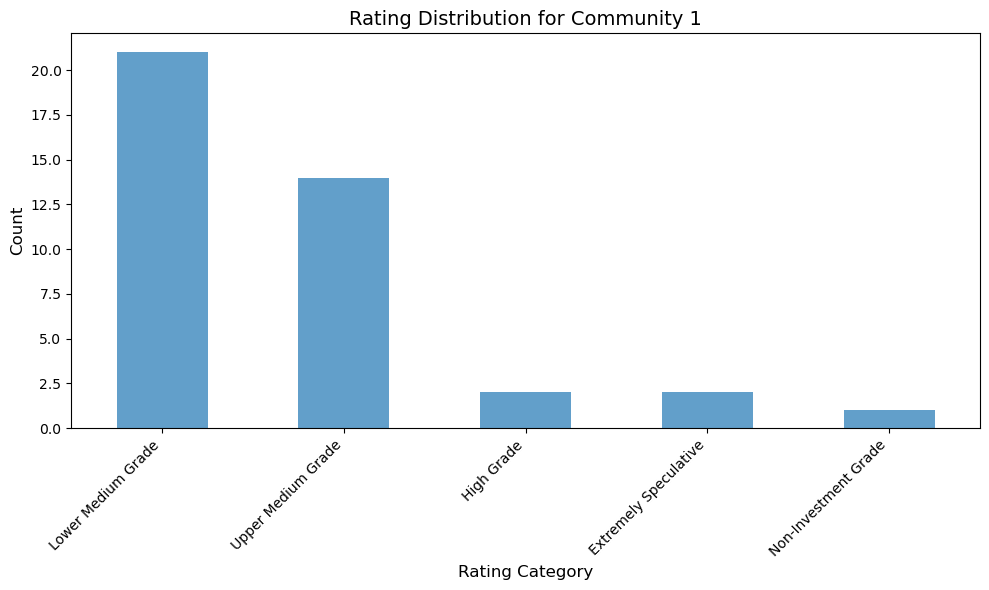

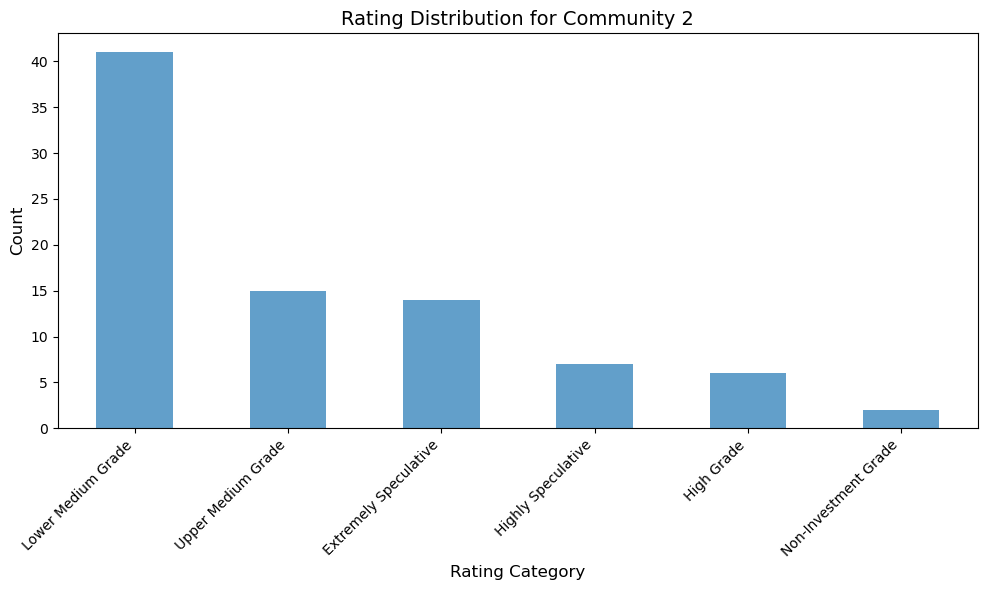

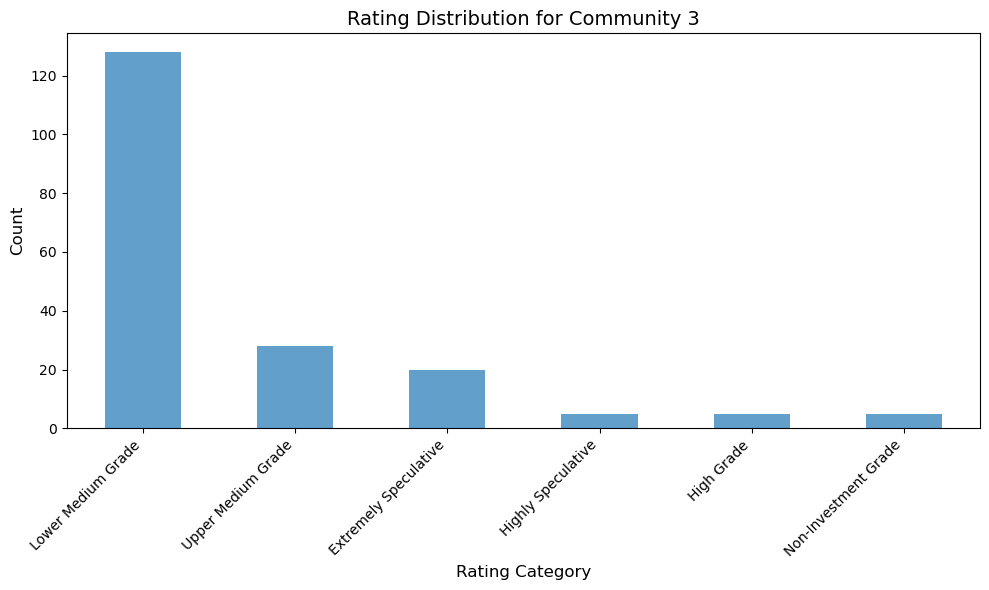

In [56]:
# Display rating distribution per community
def display_rating_distribution_per_community(metadata, company_communities):
    community_rating_distributions = []

    for i, community in enumerate(company_communities):
        community_ratings = metadata[metadata['Ticker'].isin(community)]['AverageRating'].value_counts()
        community_rating_distributions.append({
            'Community': i + 1,
            'RatingDistribution': community_ratings.to_dict()
        })

    for community_distribution in community_rating_distributions:
        print(f"Community {community_distribution['Community']}:")
        for rating, count in community_distribution['RatingDistribution'].items():
            print(f"  Rating: {rating}, Count: {count}")
        print()

# Plot the rating distribution counts for each community
def plot_rating_distribution_counts(metadata, company_communities):
    for i, community in enumerate(company_communities):
        community_ratings = metadata[metadata['Ticker'].isin(community)]['AverageRating'].value_counts()

        # Plot the distribution
        plt.figure(figsize=(10, 6))
        community_ratings.plot(kind='bar', alpha=0.7)
        plt.xlabel('Rating Category', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.title(f'Rating Distribution for Community {i + 1}', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Example usage
display_rating_distribution_per_community(metadata, company_communities)
plot_rating_distribution_counts(metadata, company_communities)

In [57]:
# Function to find the highest rating community for a ticker
def find_highest_rating_community(ticker_proxy, metadata, company_communities):
    bucket, _ = get_bucket(metadata, company_communities, ticker_proxy)
    if not bucket:
        raise ValueError(f"No bucket found for ticker {ticker_proxy}.")

    ticker_rating = bucket['Rating']

    # Count the number of tickers with the same rating in each community
    rating_counts_per_community = []
    for i, community in enumerate(company_communities):
        community_ratings = metadata[metadata['Ticker'].isin(community)]['AverageRating']
        same_rating_count = community_ratings[community_ratings == ticker_rating].count()
        rating_counts_per_community.append({
            'Community': i + 1,
            'SameRatingCount': same_rating_count
        })

    # Find the community with the highest count
    max_rating_community = max(rating_counts_per_community, key=lambda x: x['SameRatingCount'])
    return max_rating_community['Community']

# Compare original and highest rating count communities
correct_placements = 0
incorrect_placements = 0

def get_original_community(ticker_proxy, company_communities):
    for i, community in enumerate(company_communities):
        if ticker_proxy in community:
            return i + 1
    return None

for ticker_proxy in metadata['Ticker']:
    try:
        # Determine the community based on the highest rating count method
        predicted_community = find_highest_rating_community(ticker_proxy, metadata, company_communities)

        # Get the original community
        original_community = get_original_community(ticker_proxy, company_communities)

        # Compare the two
        if predicted_community == original_community:
            correct_placements += 1
        else:
            incorrect_placements += 1
    except Exception as e:
        print(f"Error processing ticker {ticker_proxy}: {e}")

# Calculate accuracy
accuracy = (correct_placements / (correct_placements + incorrect_placements)) * 100
print(f"Correct placements: {correct_placements}")
print(f"Incorrect placements: {incorrect_placements}")
print(f"Accuracy of highest rating count method: {accuracy:.2f}%")


Correct placements: 194
Incorrect placements: 122
Accuracy of highest rating count method: 61.39%


In [58]:
# Function to find the highest rating and country community for a ticker
def find_highest_rating_country_community(ticker_proxy, metadata, company_communities):
    bucket, _ = get_bucket(metadata, company_communities, ticker_proxy)
    if not bucket:
        raise ValueError(f"No bucket found for ticker {ticker_proxy}.")

    ticker_rating = bucket['Rating']
    ticker_country = bucket['Country']

    # Count the number of tickers with the same rating and country in each community
    rating_country_counts_per_community = []
    for i, community in enumerate(company_communities):
        community_data = metadata[metadata['Ticker'].isin(community)]
        same_rating_country_count = community_data[
            (community_data['AverageRating'] == ticker_rating) &
            (community_data['Country'] == ticker_country)
        ].shape[0]
        rating_country_counts_per_community.append({
            'Community': i + 1,
            'SameRatingCountryCount': same_rating_country_count
        })

    # Find the community with the highest count
    max_rating_country_community = max(rating_country_counts_per_community, key=lambda x: x['SameRatingCountryCount'])
    return max_rating_country_community['Community']
    
# Compare original and highest rating and country count communities
correct_placements = 0
incorrect_placements = 0

def get_original_community(ticker_proxy, company_communities):
    for i, community in enumerate(company_communities):
        if ticker_proxy in community:
            return i + 1
    return None

for ticker_proxy in metadata['Ticker']:
    try:
        # Determine the community based on the highest rating and country count method
        predicted_community = find_highest_rating_country_community(ticker_proxy, metadata, company_communities)

        # Get the original community
        original_community = get_original_community(ticker_proxy, company_communities)

        # Compare the two
        if predicted_community == original_community:
            correct_placements += 1
        else:
            incorrect_placements += 1
    except Exception as e:
        print(f"Error processing ticker {ticker_proxy}: {e}")

# Calculate accuracy
accuracy = (correct_placements / (correct_placements + incorrect_placements)) * 100
print(f"Correct placements: {correct_placements}")
print(f"Incorrect placements: {incorrect_placements}")
print(f"Accuracy of highest rating and country count method: {accuracy:.2f}%")

Correct placements: 220
Incorrect placements: 96
Accuracy of highest rating and country count method: 69.62%


In [60]:
# Function to find the highest rating and sector community for a ticker
def find_highest_rating_sector_community(ticker_proxy, metadata, company_communities):
    bucket, _ = get_bucket(metadata, company_communities, ticker_proxy)
    if not bucket:
        raise ValueError(f"No bucket found for ticker {ticker_proxy}.")

    ticker_rating = bucket['Rating']
    ticker_sector = bucket['Sector']

    # Count the number of tickers with the same rating and sector in each community
    rating_sector_counts_per_community = []
    for i, community in enumerate(company_communities):
        community_data = metadata[metadata['Ticker'].isin(community)]
        same_rating_sector_count = community_data[
            (community_data['AverageRating'] == ticker_rating) &
            (community_data['Sector'] == ticker_sector)
        ].shape[0]
        rating_sector_counts_per_community.append({
            'Community': i + 1,
            'SameRatingSectorCount': same_rating_sector_count
        })

    # Find the community with the highest count
    max_rating_sector_community = max(rating_sector_counts_per_community, key=lambda x: x['SameRatingSectorCount'])
    return max_rating_sector_community['Community']

# Compare original and highest rating and sector count communities
correct_placements = 0
incorrect_placements = 0

def get_original_community(ticker_proxy, company_communities):
    for i, community in enumerate(company_communities):
        if ticker_proxy in community:
            return i + 1
    return None

for ticker_proxy in metadata['Ticker']:
    try:
        # Determine the community based on the highest rating and sector count method
        predicted_community = find_highest_rating_sector_community(ticker_proxy, metadata, company_communities)

        # Get the original community
        original_community = get_original_community(ticker_proxy, company_communities)

        # Compare the two
        if predicted_community == original_community:
            correct_placements += 1
        else:
            incorrect_placements += 1
    except Exception as e:
        print(f"Error processing ticker {ticker_proxy}: {e}")

# Calculate accuracy
accuracy = (correct_placements / (correct_placements + incorrect_placements)) * 100
print(f"Correct placements: {correct_placements}")
print(f"Incorrect placements: {incorrect_placements}")
print(f"Accuracy of highest rating and sector count method: {accuracy:.2f}%")


Correct placements: 220
Incorrect placements: 96
Accuracy of highest rating and sector count method: 69.62%


In [61]:
# Function to find the highest sector and country community for a ticker
def find_highest_sector_country_community(ticker_proxy, metadata, company_communities):
    bucket, _ = get_bucket(metadata, company_communities, ticker_proxy)
    if not bucket:
        raise ValueError(f"No bucket found for ticker {ticker_proxy}.")

    ticker_sector = bucket['Sector']
    ticker_country = bucket['Country']

    # Count the number of tickers with the same sector and country in each community
    sector_country_counts_per_community = []
    for i, community in enumerate(company_communities):
        community_data = metadata[metadata['Ticker'].isin(community)]
        same_sector_country_count = community_data[
            (community_data['Sector'] == ticker_sector) &
            (community_data['Country'] == ticker_country)
        ].shape[0]
        sector_country_counts_per_community.append({
            'Community': i + 1,
            'SameSectorCountryCount': same_sector_country_count
        })

    # Find the community with the highest count
    max_sector_country_community = max(sector_country_counts_per_community, key=lambda x: x['SameSectorCountryCount'])
    return max_sector_country_community['Community']

# Compare original and highest sector and country count communities
correct_placements = 0
incorrect_placements = 0

def get_original_community(ticker_proxy, company_communities):
    for i, community in enumerate(company_communities):
        if ticker_proxy in community:
            return i + 1
    return None

for ticker_proxy in metadata['Ticker']:
    try:
        # Determine the community based on the highest sector and country count method
        predicted_community = find_highest_sector_country_community(ticker_proxy, metadata, company_communities)

        # Get the original community
        original_community = get_original_community(ticker_proxy, company_communities)

        # Compare the two
        if predicted_community == original_community:
            correct_placements += 1
        else:
            incorrect_placements += 1
    except Exception as e:
        print(f"Error processing ticker {ticker_proxy}: {e}")

# Calculate accuracy
accuracy = (correct_placements / (correct_placements + incorrect_placements)) * 100
print(f"Correct placements: {correct_placements}")
print(f"Incorrect placements: {incorrect_placements}")
print(f"Accuracy of highest sector and country count method: {accuracy:.2f}%")

Correct placements: 240
Incorrect placements: 76
Accuracy of highest sector and country count method: 75.95%


### Create a proxy using the CSRA method and then use it in the community detection method to find the community

In [74]:
#Prices data
#-----------------------------------------
prices_data = pd.read_csv('data/reshaped_data.csv')
prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)
prices_data = prices_data.set_index('Date')

#Index data
#-----------------------------------------
index_data = pd.read_csv('ITRAXX-Europe Timeseries 20241127.csv') #To be used for b0
index_data.rename(columns={'AsOf':'Date'}, inplace=True)
try:
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d-%b-%y')
except Exception as e:
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d/%b/%y')
index_data = index_data.sort_values(by='Date', ascending=True)
#Metadata
#-----------------------------------------
metadata = pd.read_csv('data/metadata_batched_ratings.csv')

#Community detection
#-----------------------------------------
correlation_matrix,T,N,company_names = create_correlation_matrix('data/eur_data_standardized_returns2.csv')
C_g = calculate_C_g(correlation_matrix, T, N)
result_communities, company_communities, modularities = recursive_spectral_method(C_g, correlation_matrix, company_names, min_size=2, modularity_threshold=0.00001)

C:\Users\iChin\AppData\Local\Temp\ipykernel_4712\820024360.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)


In [76]:
#Get matching dates in price data and index data
#-----------------------------------------
price_dates = prices_data.index.tolist()

#Extract date portion of the datetime object in the price data
index_dates = index_data['Date'].tolist()

matching_dates = [date for date in price_dates if date in index_dates]

In [90]:
tickers = prices_data.columns.to_list()[0:3] # First 3
dates = matching_dates

proxy_time_series_df = calculate_proxy_time_series(tickers, metadata, company_communities, prices_data, index_data, dates)

Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAUK on 2010-12-27 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for AAUK on 2010-12-27 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAUK on 2011-04-22 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for AAUK on 2011-04-22 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAU

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAUK on 2011-04-29 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for AAUK on 2011-04-29 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAU

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAUK on 2011-05-30 00:00:00: Solver 'CLARABEL' faile

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAUK on 2011-08-29 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for AAUK on 2011-08-29 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAUK on 2011-12-26 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for AAUK on 2011-12-26 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAU

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAUK on 2012-01-02 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for AAUK on 2012-01-02 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAUK on 2012-04-06 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for AAUK on 2012-04-06 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method f

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAUK on 2012-06-04 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for AAUK on 2012-06-04 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAUK on 2012-06-05 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for AAUK on 2012-06-05 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAUK on 2012-08-27 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for AAUK on 2012-08-27 00:00:00: Solver 'CLARABEL' failed. Try a

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAUK on 2012-12-25 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for AAUK on 2012-12-25 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with v

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAUK on 2013-01-01 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for AAUK on 2013-01-01 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solve

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAUK on 2013-04-01 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for AAUK on 2013-04-01 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another so

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Error calculating proxy using intersection method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for AAUK on 2013-05-27 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for AAUK on 2013-05-27 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Error calculating proxy using intersection community method for AAUK: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company AAUK 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABE on 2010-12-27 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABE on 2010-12-27 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=T

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not fou

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABE on 2011-04-22 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABE on 2011-04-22 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=T

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABE on 2011-04-29 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABE on 2011-04-29 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABE on 20

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABE on 2011-05-30 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABE on 2011-05-30 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABE on 2011-08-29 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABE on 2011-08-29 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Er

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABE on 2012-04-06 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABE on 2012-04-06 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=T

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABE on 2012-06-04 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABE on 2012-06-04 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: S

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve wi

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not fou

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABE on 2012-12-25 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABE on 2012-12-25 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Er

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABE on 2013-01-01 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABE on 2013-01-01 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABE on 2013-03-29 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABE on 2013-03-29 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating pr

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error calculating CSRA proxy for ABE on 2013-04-01 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABE on 2013-04-01 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABE on 2013-05-06 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABE on 2013-05-06 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Error calculating proxy using intersection method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABE on 2013-05-27 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABE on 2013-05-27 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not fou

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not fou

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not fou

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not fou

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not fou

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not fou

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not fou

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not fou

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not fou

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Error calculating proxy using intersection community method for ABE: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not fou

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 
Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company ABE 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABHLTD on 2010-12-27 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABHLTD on 2010-12-27 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA p

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABHLTD on 2011-04-22 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABHLTD on 2011-04-22 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA p

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABHLTD on 2011-04-29 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABHLTD on 2011-04-29 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA p

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABHLTD on 2011-05-30 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABHLTD on 2011-05-30 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABHLTD on 2011-08-29 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABHLTD on 2011-08-29 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABHLTD on 2011-12-26 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABHLTD on 2011-12-26 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA p

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABHLTD on 2012-04-06 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABHLTD on 2012-04-06 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA p

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABHLTD on 2012-06-04 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABHLTD on 2012-06-04 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA p

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABHLTD on 2012-08-27 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABHLTD on 2012-08-27 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABHLTD on 2012-12-25 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABHLTD on 2012-12-25 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA p

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABHLTD on 2013-01-01 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABHLTD on 2013-01-01 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABHLTD on 2013-03-29 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABHLTD on 2013-03-29 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA p

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABHLTD on 2013-05-06 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABHLTD on 2013-05-06 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Error calculating proxy using intersection method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA proxy for ABHLTD on 2013-05-27 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating CSRA community proxy for ABHLTD on 2013-05-27 00:00:00: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

Error calculating proxy using intersection community method for ABHLTD: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py

In [100]:
# Merge Proxy_CSRA into prices_data
for ticker in proxy_time_series_df['Ticker'].unique():
    # Filter the proxy time series for the specific ticker
    proxy_series = proxy_time_series_df[proxy_time_series_df['Ticker'] == ticker][['Date', 'Proxy_CSRA']]
    proxy_series.set_index('Date', inplace=True)
    
    # Add the Proxy_CSRA column to prices_data
    prices_data[ticker + '_Proxy'] = proxy_series['Proxy_CSRA']

# Run community detection on the updated prices_data
correlation_matrix, T, N, company_names = create_correlation_matrix(prices_data)
C_g = calculate_C_g(correlation_matrix, T, N)
_, company_communities, _ = recursive_spectral_method(
    C_g, correlation_matrix, company_names, min_size=2, modularity_threshold=0.00001
)

# Evaluate proxy placement accuracy
def get_community(ticker, communities):
    for i, community in enumerate(communities):
        if ticker in community:
            return i + 1
    return None

correct_placements = 0
incorrect_placements = 0

for ticker in proxy_time_series_df['Ticker'].unique():
    original_community = get_community(ticker, company_communities)
    proxy_community = get_community(ticker + '_Proxy', company_communities)
    
    if original_community == proxy_community:
        correct_placements += 1
    else:
        incorrect_placements += 1

# Calculate accuracy
accuracy = (correct_placements / (correct_placements + incorrect_placements)) * 100
print(f"Correct placements: {correct_placements}")
print(f"Incorrect placements: {incorrect_placements}")
print(f"Proxy placement accuracy: {accuracy:.2f}%")


Correct placements: 1
Incorrect placements: 2
Proxy placement accuracy: 33.33%
